In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

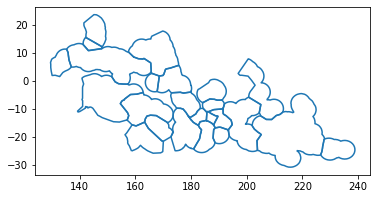

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
date = 'this month'

In [11]:
year = dateparser.parse(date).year

In [12]:
month = dateparser.parse(date).month

In [13]:
print(f"{year} - {month}")

2021 - 12


### read the probabilistic forecasts from the GCMs now 

### provider 

In [14]:
provider = 'CDS'

#### list of GCMs to inlude 

In [15]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

#### period (`monthly` or `seasonal`)

In [16]:
# period = 'monthly'
period = 'seasonal'

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [18]:
quantile = 'tercile'

### variable 

In [19]:
varname = 'precip'

### domain 

In [20]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [21]:
domain = 'Water_Watch'

In [22]:
domain = domains.domains[domain]

In [23]:
domain

[125, 240, -35, 25]

### paths to the realtime forecasts

In [24]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [25]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [26]:
[f.name for f in lfiles]

[]

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [27]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

OSError: no files to open

In [ ]:
probs

### interpolate

In [ ]:
probs = utils.interp(probs, interp_factor=6)

In [ ]:
probs = probs.mean('GCM')

In [ ]:
probs

### make sure the probabilities sum to 100 over the decile dimension 

In [ ]:
probs.sum(quantile).squeeze().sel(step=3)['precip'].plot()

In [ ]:
probs

In [ ]:
probs.sel(step=3).squeeze()['precip'].plot(col=quantile)

### EEZ shapes 

In [ ]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [ ]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

In [ ]:
EEZs.boundary.plot(); 

In [ ]:
probs

In [ ]:
probs = geo.make_mask_from_gpd(probs, merged_EEZs, subset=False, mask_name='mask')

In [ ]:
probs

In [ ]:
thresholds = [0, 10, 20, 40, 50, 60, 70, 100.0]

In [ ]:
hexes = ['#1549b0','#62a3bf','#ffffff','#f5e464','#e39f39','#ff1212','#7d0f05']

In [ ]:
import matplotlib

In [ ]:
cmap = matplotlib.colors.ListedColormap(hexes, name='probabilities')

### parametrized terciles climatological values 

In [ ]:
from matplotlib import pyplot as plt 
from cartopy import crs as ccrs

In [ ]:
from calendar import month_name

In [ ]:
month_name = list(month_name) + list(month_name)[1:]

### choose the step for the forecast here 

In [ ]:
period

In [ ]:
step = 4

In [ ]:
if period == 'monthly': 
    label_period = month_name[month + step]
elif period == 'seasonal': 
    label_period = month_name[month + step - 2] + " - " + month_name[month + step]

In [ ]:
month

In [ ]:
label_period.replace(" - ","_")

In [ ]:
dset = probs['precip'] * probs['mask']

In [ ]:
dset = dset.to_dataset(name='precip')

In [ ]:
f, axes = plt.subplots(ncols=3, figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax = axes[0]
ax.coastlines(resolution='10m')
im1 = dset['precip'].sel(step=step, tercile=1).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob(precipitation < lower tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

ax = axes[1]
ax.coastlines(resolution='10m')
im2 = dset['precip'].sel(step=step, tercile=2).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title(f"C3S MME, Prob(lower tercile < precipitation < upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

cbar_ax = ax.axes.inset_axes([0, -0.125, 1, 0.05])

cb = plt.colorbar(im2, cax=cbar_ax, orientation='horizontal')

cb.set_label("%")

ax = axes[2]
ax.coastlines(resolution='10m')
im3 = dset['precip'].sel(step=step, tercile=3).squeeze().plot.contourf(ax=ax, levels=thresholds, cmap=cmap, extend='neither', transform=ccrs.PlateCarree(), add_colorbar=False, title='')
ax.set_title(f"C3S MME, Prob(precipitation > upper tercile)\n{label_period}")
plot.add_geom(ax, geoms=EEZs)

f.savefig(f'/home/nicolasf/Desktop/C3S_MME_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, bbox_inches='tight', facecolor='w')


In [ ]:
dset

In [ ]:
probs

In [ ]:
probs_t = probs[['precip']]

In [ ]:
probs_t = probs_t.idxmax(dim='tercile')

In [ ]:
probs_t = probs_t.squeeze()

In [ ]:
probs_t.sel(step=3)['precip'].plot()

In [ ]:
probs['category'] = probs_t['precip']

In [ ]:
probs

In [ ]:
cmap_1 = plt.cm.Oranges

In [ ]:
cmap_2 = plt.cm.gray_r

In [ ]:
cmap_3 = plt.cm.Greens

In [ ]:
ticks = np.arange(40,110,10)

In [ ]:
probs['category'] = probs['category'] * probs['mask']

In [ ]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(13,8))

im1 = probs.where(probs['category'] == 1).squeeze().sel(tercile=1,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_1, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_1 = ax.axes.inset_axes([0.001, -0.05, 0.3, 0.025])

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'both', 'drawedges':True, 'ticks':np.arange(40,110,10), 'aspect':15, 'orientation':'horizontal'}

cb1 = plt.colorbar(im1, cax=cbar_ax_1, **cbar_kwargs)

cb1.set_ticklabels(ticks)

cb1.ax.tick_params(labelsize=14)

cb1.set_label("below lower tercile (%)", fontsize=14)

im2 = probs.where(probs['category'] == 2).squeeze().sel(tercile=2, step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_2, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_2 = ax.axes.inset_axes([0.35, -0.05, 0.3, 0.025], )

cb2 = plt.colorbar(im2, cax=cbar_ax_2, **cbar_kwargs)

cb2.set_ticklabels(ticks)

cb2.ax.tick_params(labelsize=14)

cb2.set_label("middle tercile (%)", fontsize=14)

im3 = probs.where(probs['category'] == 3).squeeze().sel(tercile=3,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_3, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_3 = ax.axes.inset_axes([0.7, -0.05, 0.3, 0.025], )

cb3 = plt.colorbar(im3, cax=cbar_ax_3, **cbar_kwargs)

cb3.set_ticklabels(ticks)

cb3.ax.tick_params(labelsize=14)

cb3.set_label("above upper tercile (%)", fontsize=14)

ax.coastlines(resolution='10m')

plot.add_geom(ax, geoms=EEZs)

ax.set_title("")

title = f"C3S Multi-model ensemble probabilistic\nprecipitation tercile forecast\n{label_period}"

ax.text(0.99, 0.97, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# ax.set_extent()

ax.text(0.0065, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

# plot.insert_logo(logo_path='../../ICU_Water_Watch/logo/',ax=ax)

ax.set_extent(domain, crs = ccrs.PlateCarree())

f.savefig(f'/home/nicolasf/Desktop/C3S_MME_most_likely_category_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, bbox_inches='tight', facecolor='w')

In [ ]:
fpath = pathlib.Path('/home/nicolasf/operational/ICU_Web/C3S/')

In [ ]:
f.savefig(fpath.joinpath(f'C3S_MME_most_likely_category_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, bbox_inches='tight', facecolor='w')

### list the files and get the number of ensemble members 

In [ ]:
dpath  = pathlib.Path('/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/')

In [ ]:
lfiles = list(dpath.rglob(f"*from_{year}_{month}_*.netcdf"))

In [ ]:
nmembers = []
for fname in lfiles: 
    dset = xr.open_dataset(fname)
    nmembers.append(dset.dims['number'])

In [ ]:
print(f"The forecasts from {year} - {month} contain {np.array(nmembers).sum()} members")

In [ ]:
domain

In [ ]:
probs

In [ ]:
country_name = 'Fiji'

In [ ]:
coastlines = geo.get_coastlines(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

In [ ]:
print(f"   --> processing {country_name} for the SPI\n")

coastline = coastlines.query(f"country_na == '{country_name}'")

EEZ = EEZs.query(f"COUNTRYNAM == '{country_name}'")

In [ ]:
subset_probs = geo.make_mask_from_gpd(probs, EEZ, subset=True, mask_name='EEZ')

In [ ]:
subset_probs

In [ ]:
dataarray = subset_probs['precip'] * subset_probs['EEZ']

In [ ]:
dataarray.sel(step=3).squeeze().plot(col='tercile')

In [ ]:
lon_min = np.floor(subset_probs.lon.data.min())
lon_max = np.ceil(subset_probs.lon.data.max())
lat_min = np.floor(subset_probs.lat.data.min())
lat_max = np.ceil(subset_probs.lat.data.max())

# make xlocs and ylocs 

xlocs = np.linspace(lon_min, lon_max + 1, 5, endpoint=True)
ylocs = np.linspace(lat_min, lat_max + 1, 5, endpoint=True)

xlocs[xlocs > 180] -= 360 # fix the longitudes to go from -180 to 180 (for plotting)

In [ ]:
data = subset_probs[['precip']] * subset_probs['EEZ']

In [ ]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(13,8))

im1 = data.where(probs['category'] == 1).squeeze().sel(tercile=1,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_1, add_colorbar=False, transform=ccrs.PlateCarree())

# cbar_ax_1 = ax.axes.inset_axes([0.001, -0.05, 0.3, 0.025])

cbar_ax_1 = ax.axes.inset_axes([1.1, 0, 0.025, 0.3])

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'both', 'drawedges':True, 'ticks':np.arange(40,110,10), 'aspect':15, 'orientation':'vertical'}

cb1 = plt.colorbar(im1, cax=cbar_ax_1, **cbar_kwargs)

cb1.set_ticklabels(ticks)

cb1.ax.tick_params(labelsize=10)

cb1.set_label("below lower tercile (%)", fontsize=12)

im2 = data.where(probs['category'] == 2).squeeze().sel(tercile=2, step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_2, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_2 = ax.axes.inset_axes([1.1, 0.35, 0.025, 0.3])

cb2 = plt.colorbar(im2, cax=cbar_ax_2, **cbar_kwargs)

cb2.set_ticklabels(ticks)

cb2.ax.tick_params(labelsize=10)

cb2.set_label("middle tercile (%)", fontsize=12)

im3 = data.where(probs['category'] == 3).squeeze().sel(tercile=3,step=step)['precip'].plot.contourf(levels=np.arange(40,110,10), ax=ax, cmap = cmap_3, add_colorbar=False, transform=ccrs.PlateCarree())

cbar_ax_3 = ax.axes.inset_axes([1.1, 0.7, 0.025, 0.3])

cb3 = plt.colorbar(im3, cax=cbar_ax_3, **cbar_kwargs)

cb3.set_ticklabels(ticks)

cb3.ax.tick_params(labelsize=10)

cb3.set_label("above upper tercile (%)", fontsize=12)

# ax.coastlines(resolution='10m')

plot.add_geom(ax=ax, geoms=EEZ)

title = f"C3S Multi-model ensemble probabilistic\nprecipitation tercile forecast\n{label_period}"

ax.set_title(title)

ax.text(0.95, 0.95, f"{country_name}", transform=ax.transAxes, fontsize=15, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center')

ax.set_extent([lon_min, lon_max, lat_min, lat_max])

gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=xlocs, ylocs=ylocs, crs=ccrs.PlateCarree())

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

coastlines.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=1, color='0.4')
coastline.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=1, color='k')


In [ ]:
f.savefig(f'/home/nicolasf/Desktop/{utils.sanitize_name(country_name)}_C3S_MME_most_likely_category_{period}_{quantile}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, bbox_inches='tight', facecolor='w')